# Installation of packages

For this code, we will use CUDA v10.1 with cuDNN v7.6.5 installed on a Windows 10 PC. Please ensure that you have a CUDA-compatible GPU or graphics card (a list can be found <a href="https://developer.nvidia.com/cuda-gpus"> here</a>, then download CUDA from  <a href="https://developer.nvidia.com/cuda-10.1-download-archive-base"> here </a> and cuDNN from <a href="https://developer.nvidia.com/rdp/cudnn-download"> here</a>. Please make sure to download the correct cuDNN corresponding to CUDA v10.1, or there may be package incompatibility issues. See the screenshot below:

<img src="cudnn_download.png" alt="cudnn_download" height="600" width="600">

Alternatively, if you have Anaconda prompt installed, try entering `conda install cudatoolkit==10.1.143 cudnn==7.6.5` into the command line to install them.

In addition, the code will assume that you are running TensorFlow 2.0 with the prerequisite packages installed. For the exact packages and versions, please refer to the `baseline_env.yml` file that has been placed in the same folder as this notebook.

# Check hardware setup

The following code checks if the GPU on your system is available for training. If your system has no GPU or does not have the required libraries to use it, the code will still run, but it will use the CPU, which will be markedly slower.
(To make sure TF2 works properly: https://towardsdatascience.com/tensorflow-gpu-installation-made-easy-use-conda-instead-of-pip-52e5249374bc)

In [1]:
import tensorflow
import tensorflow as tf

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU'))) # Should be nonzero

Num GPUs Available:  2


In [3]:
tensorflow.config.list_physical_devices('GPU') # Should list at least one GPU device (e.g. [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]).

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
from tensorflow.python.platform import build_info
print('Tensorflow version: {}'.format(tensorflow.__version__)) # Should be 2.6.0, dcase_joseph: tf 2.5

Tensorflow version: 2.5.0


# Baseline model implementation

Now, we implement the baseline model for DCASE 2020 Task 1B. Firstly, we shall import the required packages.

Note that Keras is now packaged as part of Tensorflow 2.0, so it is now a subpackage under `tensorflow`. To use any of the old Keras commands, start by importing `tensorflow.keras` instead of `keras` itself.

In [5]:
import numpy as np
import pandas as pd
np.random.seed(2022)
import pathlib
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Include this line to force TensorFlow to run with the CPU instead of GPU. It must be placed BEFORE importing tensorflow,
                                          # otherwise tensorflow will default to the GPU for computing. Will need to restart kernel if you want to run with GPU again.
# os.environ["CUDA_VISIBLE_DEVICES"]="2" # Include this line if you have multiple GPUs available for training and want to select the 2nd GPU.
                                         # If you only have one GPU then leaving it empty is fine. Need tensorflow-gpu installed + a GPU in your system + CUDA drivers.

import tensorflow
tensorflow.random.set_seed(2022) # ALWAYS set the random seed for tensorflow before importing any other related Keras packages.
                                 # If using Tensorflow versions less than 2.0.0, change this line to tensorflow.set_random_seed(2019)

import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt

# Allow matplotlib plots to display properly in the notebook.
%matplotlib inline 

from datetime import datetime # Used to label output model files.
from useful_functions import * # Load our own useful_functions module.

# Data exploration

Let's look at a sample track from the 10-class dataset. Note that all the data are recorded with a sampling frequency of 44100Hz, and are exactly 1 second long. Change the filename argument in `librosa.load` to load different files from the dataset.

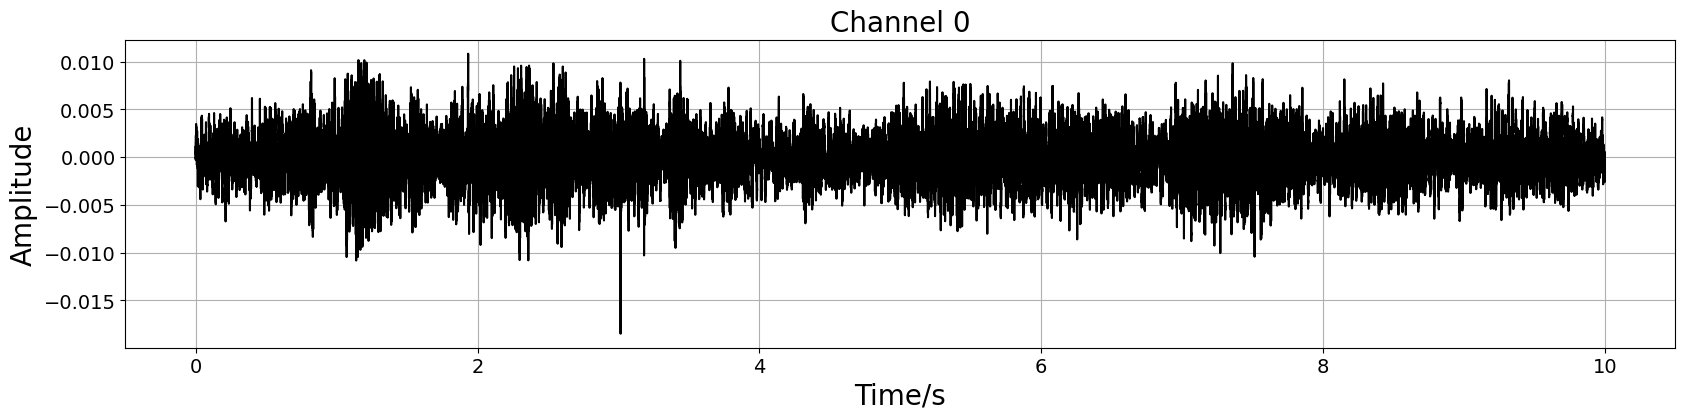

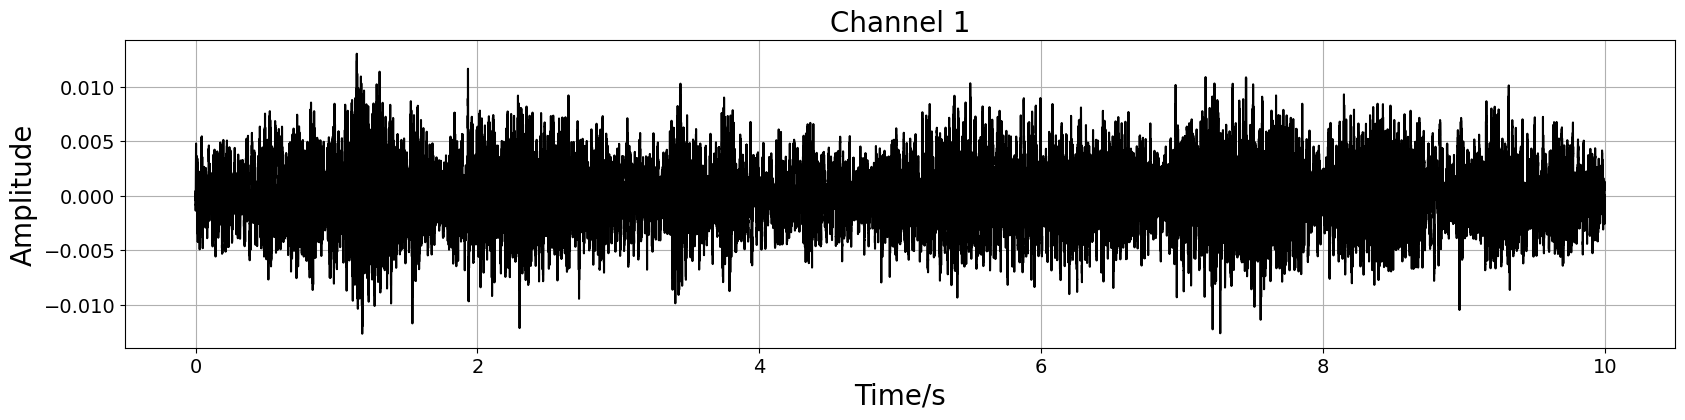

(2, 480000)

In [6]:
filedir = 'D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/audio/'
#D:\Sean\DCASE2019\TAU-urban-acoustic-scenes-2019-development\audio
x, sr = librosa.load(filedir + 'airport-barcelona-0-0-a.wav',
                 mono = False,
                 sr = 48000)

plot_time_domain_signal_and_track(x.T, sr = sr, normalize_audio_player=True)
x.shape

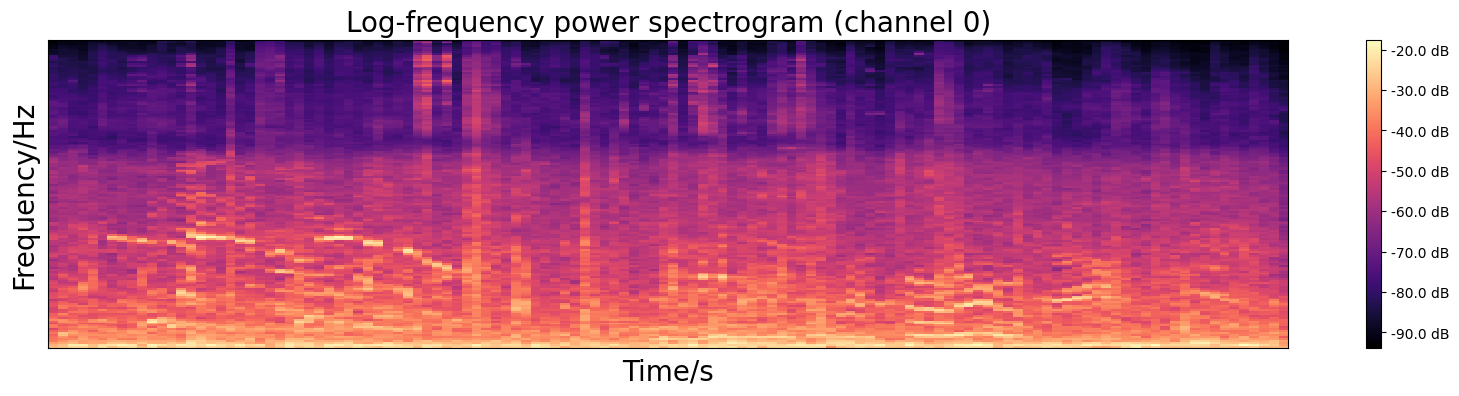

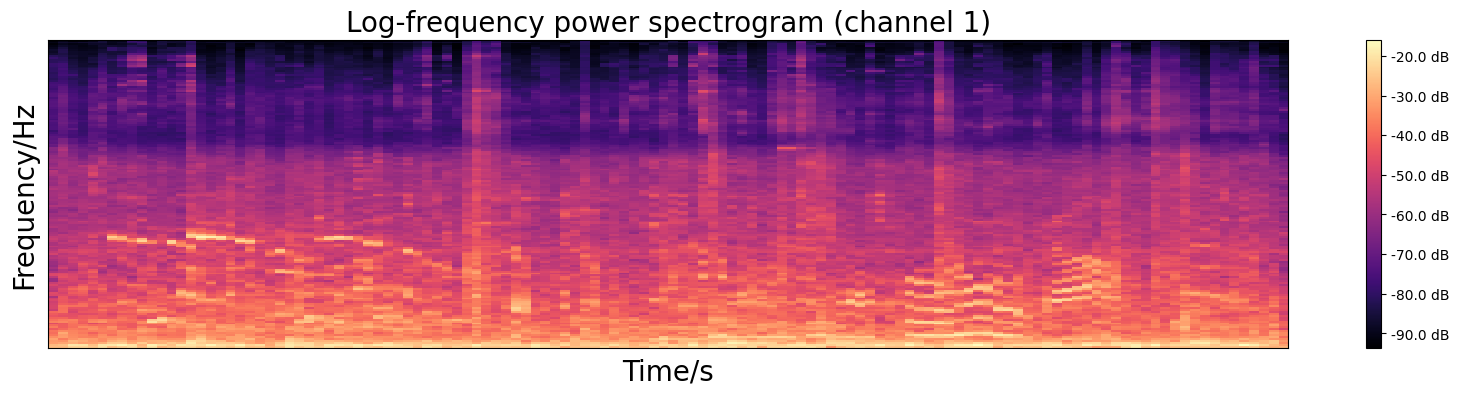

(160, 126, 2)

In [7]:
s = audio_to_mel_magnitude_spectrogram(x,
                                       sr=sr,
                                       n_fft=int(0.16*sr),
                                       hop_length=int(0.08*sr),
                                       center = True, 
                                       n_mels = 160,
                                       fmin = 0,
                                       fmax = sr//2,
                                       ref = 100, 
                                       plot_spectrogram = True)
s.shape

# Feature extraction

In this section, we extract mel magnitude spectrograms from the raw audio data making up the training and evaluation set separately. Firstly, we shall read the metadata .csv file provided by the organisers and verify that all files in the .csv file do indeed exist as audio files in the dataset. The code block below should run without printing anything or returning any error.

In [8]:
train_files = pd.read_csv(r'D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold1_train.csv',delimiter = '\t')

#train_files.pop(0)

#print(train_files)
eval_files = pd.read_csv(r'D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold1_evaluate.csv',
                      delimiter = '\t')

#eval_files.pop(0)

# Check that all files indeed exist.
for i in range(len(eval_files)):
    filepath = "D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development" + os.sep + train_files.loc[i].at["filename"]
    if not os.path.exists(filepath):
        print(filepath + ' does not exist')


Let's also check the number of files we have in the training and evaluation set:

In [9]:
print('Number of training files: ' + str(len(train_files))) # 139620
print('Number of evaluation files: ' + str(len(eval_files))) # 29680
print(train_files)
print(eval_files)

Number of training files: 9185
Number of evaluation files: 4185
                                             filename        scene_label
0               audio/airport-lisbon-1000-40000-a.wav            airport
1                     audio/bus-lyon-1001-40001-a.wav                bus
2         audio/shopping_mall-lisbon-1002-40002-a.wav      shopping_mall
3       audio/street_pedestrian-lyon-1003-40003-a.wav  street_pedestrian
4     audio/street_pedestrian-lisbon-1004-40004-a.wav  street_pedestrian
...                                               ...                ...
9180                 audio/tram-vienna-202-6117-a.wav               tram
9181                 audio/tram-vienna-202-6118-a.wav               tram
9182                 audio/tram-vienna-202-6119-a.wav               tram
9183                 audio/tram-vienna-202-6120-a.wav               tram
9184                 audio/tram-vienna-202-6121-a.wav               tram

[9185 rows x 2 columns]
                                   

This corresponds to an approximate 70:30 split of the dataset (note that 1030 files were completely unused).

## Training features

Firstly we extract the features (Raw Waveforms) from the training data with the parameters specified by Jung et al. This should take about 2-3 minutes to run. The original dataset used by the author was recorded at 48KHz native and no downsampling was performed. We will sample at native sampling frequency of 44.1KHz with the TAU 2022 datatset

In [ ]:
start_time = datetime.now()
train_features = np.empty(shape=(len(train_files),480000,2))
train_features.shape
train_files = pd.read_csv(r'D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold1_train.csv',delimiter = '\t')
for row_index, row in train_files.iterrows():
    print(f'{row_index}/{len(train_files)}',end='\r')
    x,sr = librosa.load('D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/'+row.filename,mono=False,sr=sr)
    n_channels, n_samples = x.shape

    if n_channels != 2:
        print(f'ERROR: {row.filename} does not have 2 channels, we got {n_channels} channels instead.')
    
    if np.abs(n_samples - 480000) > 1:
        print(f'ERROR: {row.filename} does not have 480k samples, we got {n_samples} samples instead.')
        
        
    if n_samples > 480000:
        x=x[:,:480000]
    if n_samples <480000:
        x=np.pad(x,((0,0),(0,1)),'constant')
        
    if not x.shape == (2,480000):
        print(f'ERROR: I fucked up')
        
    train_features[row_index] = x.T
train_features[0].dtype

(9185, 480000, 2)

````
for i in range(len(train_files)):
    filepath = "D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development" + os.sep + train_files.loc[i].at["filename"]
    #D:\Sean\DCASE2019\TAU-urban-acoustic-scenes-2019-development\audio
    x, sr = librosa.load(filepath, mono=False, sr = sr)
    # s = audio_to_mel_magnitude_spectrogram(x,
    #                                    sr=sr,
    #                                    n_fft=int(0.16*sr),
    #                                    hop_length=int(0.08*sr),
    #                                    center = True, 
    #                                    n_mels = 160,
    #                                    fmin = 0,
    #                                    fmax = sr//2,
    #                                    ref = 100.0, 
    #                                    plot_spectrogram = False)
    
    train_features[i] = x.T
    if i%1000 == 0:
        print('Now on training sample: ' + str(i))
end_time = datetime.now()
print('Time elapsed: ' + str(end_time - start_time))
```

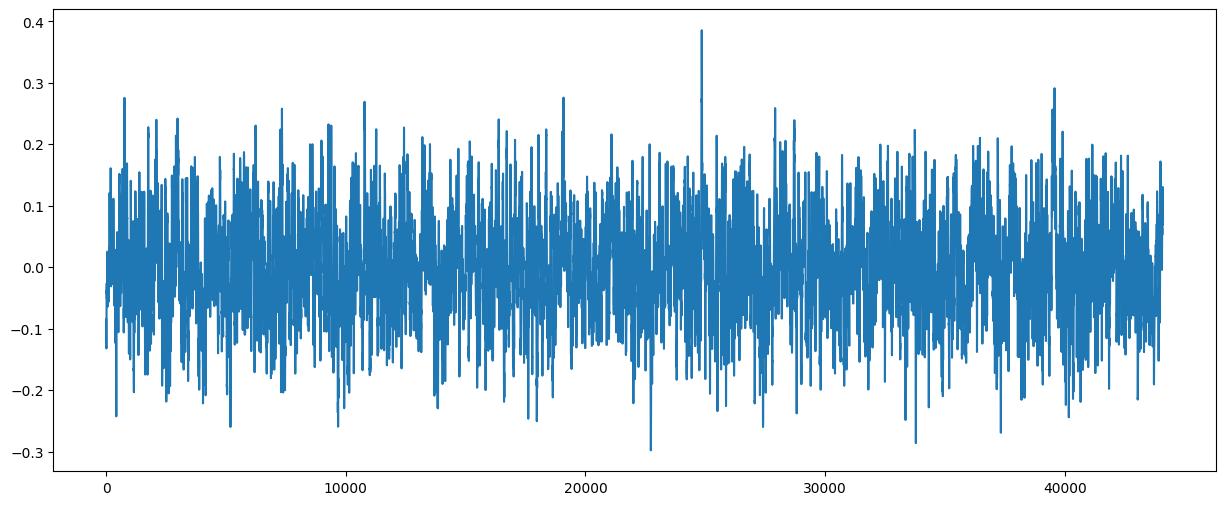

In [247]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(train_features[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


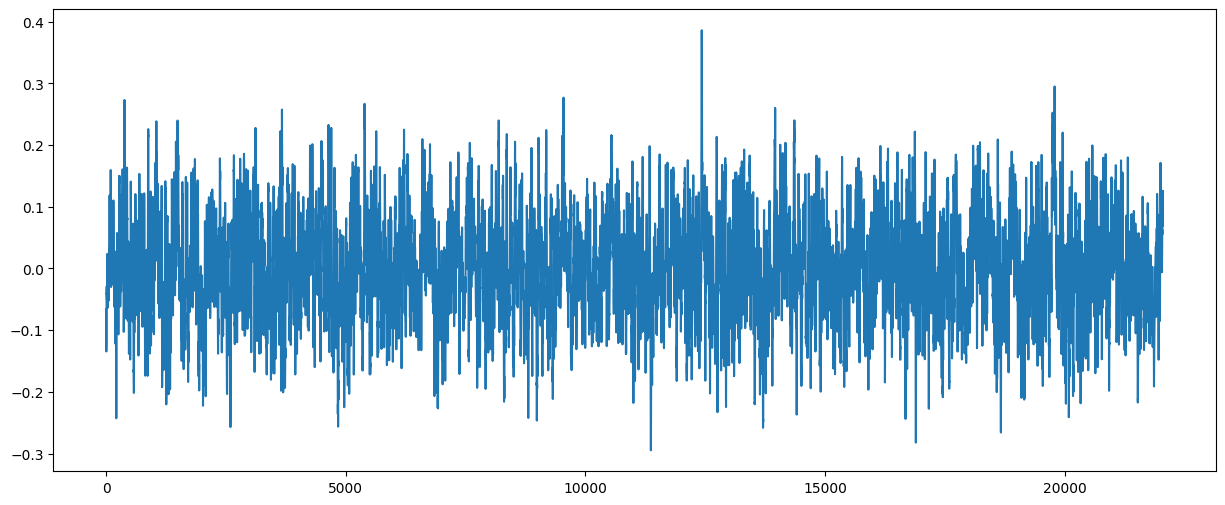

In [252]:
import librosa
x,sr = librosa.load("D:/Sean/DCASE/datasets/Extract_to_Folder/TAU-urban-acoustic-scenes-2022-mobile-development/audio/airport-lisbon-1000-40000-0-a.wav")
plt.figure(figsize=(15,6))
plt.plot(x)

print(train_labels[0])

## Evaluation features

Next, we extract the waveforms for the evaluation (test) set with the same parameters. This should take about 1-2 minutes to run.

In [27]:
start_time = datetime.now()
eval_features = np.empty(shape=(len(eval_files),480000,2))
eval_features.shape
eval_files = pd.read_csv(r'D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold1_evaluate.csv',delimiter = '\t')
for row_index, row in eval_files.iterrows():
    print(f'{row_index}/{len(eval_files)}',end='\r')
    x,sr = librosa.load('D:/Sean/DCASE2019/TAU-urban-acoustic-scenes-2019-development/'+row.filename,mono=False,sr=sr)
    n_channels, n_samples = x.shape

    if n_channels != 2:
        print(f'ERROR: {row.filename} does not have 2 channels, we got {n_channels} channels instead.')
    
    if np.abs(n_samples - 480000) > 1:
        print(f'ERROR: {row.filename} does not have 480k samples, we got {n_samples} samples instead.')
        
        
    if n_samples > 480000:
        x=x[:,:480000]
    if n_samples <480000:
        x=np.pad(x,((0,0),(0,1)),'constant')
        
    if not x.shape == (2,480000):
        print(f'ERROR: I fucked up')
        
    eval_features[row_index] = x.T

## Labels

Lastly, we extract the labels for each data sample. There are ten possible class labels for the data samples in this task: airport, shopping mall, metro station, street(pedestrian), public square, street(traffic), tram, bus, metro and park

In [29]:
class_labels = ['airport','shopping_mall','metro_station', 'street_pedestrian', 'public_square','street_traffic','tram','bus','metro','park']

In [30]:
# Make directory to save features if it doesn't already exist.
if not os.path.exists('D:/Sean/' + 'features_Sean'):
    os.makedirs('D:/Sean/' + 'features_Sean')
np.save('D:/Sean/features_Sean/'+'train_features_2019.npy',train_features,allow_pickle=True)
np.save('D:/Sean/features_Sean/'+'eval_features_2019.npy',eval_features,allow_pickle=True)

In [ ]:
train_labels = np.empty(shape = (len(train_files),))
for i in range(len(train_files)):
    train_labels[i] = class_labels.index(train_files.loc[i].at["scene_label"])
np.save('D:/Sean/features_Sean/'+'train_labels_2019.npy',train_labels,allow_pickle=True)

In [ ]:
eval_labels = np.empty(shape = (len(eval_files),))
for i in range(len(eval_files)):
    eval_labels[i] = class_labels.index(eval_files.loc[i].at["scene_label"])
np.save('D:/Sean/features_Sean/'+'baseline_eval_labels_2019.npy',eval_labels,allow_pickle=True)

In [6]:
from tensorflow.keras.utils import to_categorical

train_features = np.load('D:/Sean/features_Sean/'+'train_features_2019.npy',allow_pickle=True)
eval_features = np.load('D:/Sean/features_Sean/'+'eval_features_2019.npy',allow_pickle=True)
# train_features = np.load('D:/Sean/features_Sean/'+'train_features_logmel160.npy',allow_pickle=True)
# eval_features = np.load('D:/Sean/features_Sean/'+'eval_features_logmel160.npy',allow_pickle=True)
train_labels = to_categorical(np.load('D:/Sean/features_Sean/'+'train_labels_2019.npy',allow_pickle=True))
eval_labels = to_categorical(np.load('D:/Sean/features_Sean/'+'baseline_eval_labels_2019.npy',allow_pickle=True))

In [300]:
train_features = {"spec": train_features}
eval_features = {"spec":eval_features}

# Model architecture

In this section, we train the baseline model with Residual Blocks as specified by Jung et al. Firstly, we will load all the features and labels that were previously generated:

Secondly, we will define the layers of the model. The model consists mainly of two convolutional layers, separated by a batch-norm layer followed by a leaky ReLU activation layer, followed by  7 residual blocks, a batch-norm layer followed by a leaky ReLU activation layer. Finally, the features pass through a global max pool and global average pool before reaching a dense layer with 10 neurons.

In [115]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv1D, Dense, Dropout, Flatten, Input, MaxPooling2D, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Reshape, Add
change_dim = False
#nb_filts = [128, [128, 64, 64], [64, 128,128], [128, 128,128], 128]
nb_filts = [64,128]
class Residual_block(Model):
    def __init__(self, nb_filts):
        super(Residual_block, self).__init__()
        self.conv1 = Conv1D(nb_filts,kernel_size=3, padding = 'same', strides = 1,data_format='channels_last')
        self.bn1 = BatchNormalization(axis=-1)
        self.lrelu1 = LeakyReLU(alpha=0.3)
        self.conv2 = Conv1D(nb_filts,kernel_size=3,padding='same',strides=1,data_format='channels_last')
        self.bn2 = BatchNormalization(axis=-1)
        self.lrelu2 = LeakyReLU(alpha=0.3)
        self.mp = MaxPool1D(pool_size=3)
        self.add = Add()
        
    def call(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.lrelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.add([identity,out])
        out = self.lrelu2(out)
        out = self.mp(out)
        return out
    
class Residual_block_down(Model):
    def __init__(self, nb_filts):
        super(Residual_block_down, self).__init__()
        self.conv1 = Conv1D(filters=128,kernel_size=1, padding = 'same', strides = 1,data_format='channels_last')
        self.bn1 = BatchNormalization(axis=-1)
        self.lrelu1 = LeakyReLU(alpha=0.3)
        self.conv2 = Conv1D(filters=128,kernel_size=3,padding='same',strides=1,data_format='channels_last')
        self.bn2 = BatchNormalization(axis=-1)
        self.mp = MaxPool1D(pool_size=3)
        self.add = Add()
        self.lrelu2 = LeakyReLU(alpha=0.3)
        self.conv_downsample = Conv1D(filters=128, kernel_size=3, padding = 'same',strides=1, data_format='channels_last')  
        
    def call(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.lrelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.conv_downsample(identity)
        out = self.add([identity,out])
        out = self.lrelu2(out)
        out = self.mp(out)
        return out
class raw_CNN_c(Model):
    def __init__(self):
        super(raw_CNN_c, self).__init__()
        
        self.first_conv = Conv1D(filters = 128, kernel_size=12,strides=12)
        self.first_bn = BatchNormalization(axis=-1)
        self.first_lrelu = LeakyReLU(alpha=0.3)
        self.conv1 = Conv1D(filters=64, kernel_size =3, strides = 1)
        self.bn2 = BatchNormalization(axis=-1)
        self.lrelu2 = LeakyReLU(alpha=0.3)
        self.conv2 = Conv1D(filters=64,kernel_size=3,strides=1)
        self.bn3 = BatchNormalization(axis=-1)
        self.conv3 = Conv1D(filters=64,kernel_size=3,strides=1)
        self.lrelu3 = LeakyReLU(alpha=0.3)
        self.block0 = Residual_block(nb_filts = 64)
        self.block1 = Residual_block_down(nb_filts = 128)
        self.block2 = Residual_block(nb_filts = 128)
        self.block3 = Residual_block(nb_filts = 128)
        self.block4 = Residual_block(nb_filts = 128)
        self.block5 = Residual_block(nb_filts = 128)
        self.block6 = Residual_block(nb_filts = 128)
        self.last_conv = Conv1D(filters = 128, kernel_size = 1, strides=1)
        self.last_bn = BatchNormalization(axis=-1)
        self.last_lrelu = LeakyReLU(alpha=0.3)
        self.mp = MaxPool1D(pool_size=3)
        self.global_maxpool = GlobalMaxPool1D()
        self.global_avgpool = GlobalAveragePooling1D()
        self.fc1 = Dense(units=64)
        self.fc2 = Dense(units=10)
        # self.reshape = Reshape((128,1))
    def call(self,x):
        
        x = self.first_conv(x)
        x = self.first_bn(x)
        x = self.first_lrelu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.conv3(x)
        x = self.lrelu3(x)
        x = self.mp(x)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)

        x = self.last_conv(x)
        x = self.last_bn(x)
        x = self.last_lrelu(x)
        
        x_avg = self.global_avgpool(x)
        #         ## may or may not need to reshape due to data_format declaration above##
        # x_avg = self.reshape((128,1))
        x_max = self.global_maxpool(x)
        # ## may or may not need to reshape due to data_format declaration above
        # x_max = self.reshape((128,1))
        # x_max = tf.cast(x_max,tf.int32)
        x = tf.concat((x_avg,x_max),axis=1)
        x = self.fc1(x)
        y = self.fc2(x)
        
        # Train the NN on CCE, then take outputs of fc1 for use in SVM
        return {'output':y , 'intvals': x}
    def summary(self):
        x= Input(shape=(480000, 2))
        # x= Input(shape=(160,13))
        model = Model(inputs=[x],outputs=self.call(x))
        return model.summary()
    def build_graph(self):
        x = tf.keras.layers.Input(shape=(480000,2))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    
def get_model():
  return raw_CNN_c(Model)

    
        

In [149]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv1D, Dense, Dropout, Flatten, Input, MaxPooling2D, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Reshape, Add
change_dim = False
#nb_filts = [128, [128, 64, 64], [64, 128,128], [128, 128,128], 128]
nb_filts = [64,128]
class Residual_block(Model):
    def __init__(self, nb_filts):
        super(Residual_block, self).__init__()
        self.conv1 = Conv1D(nb_filts,kernel_size=3, padding = 'same', strides = 1,data_format='channels_last')
        self.bn1 = BatchNormalization(axis=-1)
        self.lrelu1 = LeakyReLU(alpha=0.3)
        self.conv2 = Conv1D(nb_filts,kernel_size=3,padding='same',strides=1,data_format='channels_last')
        self.bn2 = BatchNormalization(axis=-1)
        self.lrelu2 = LeakyReLU(alpha=0.3)
        self.mp = MaxPool1D(pool_size=3)
        self.add = Add()
        
    def call(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.lrelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.add([identity,out])
        out = self.lrelu2(out)
        out = self.mp(out)
        return out
    
class Residual_block_down(Model):
    def __init__(self, nb_filts):
        super(Residual_block_down, self).__init__()
        self.conv1 = Conv1D(filters=128,kernel_size=1, padding = 'same', strides = 1,data_format='channels_last')
        self.bn1 = BatchNormalization(axis=-1)
        self.lrelu1 = LeakyReLU(alpha=0.3)
        self.conv2 = Conv1D(filters=128,kernel_size=3,padding='same',strides=1,data_format='channels_last')
        self.bn2 = BatchNormalization(axis=-1)
        self.mp = MaxPool1D(pool_size=3)
        self.add = Add()
        self.lrelu2 = LeakyReLU(alpha=0.3)
        self.conv_downsample = Conv1D(filters=128, kernel_size=3, padding = 'same',strides=1, data_format='channels_last')  
        
    def call(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.lrelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.conv_downsample(identity)
        out = self.add([identity,out])
        out = self.lrelu2(out)
        out = self.mp(out)
        return out
class raw_CNN_c(Model):
    def __init__(self):
        super(raw_CNN_c, self).__init__()
        
        self.first_conv = Conv1D(filters = 128, kernel_size=12,strides=12)
        self.first_bn = BatchNormalization(axis=-1)
        self.first_lrelu = LeakyReLU(alpha=0.3)
        self.conv1 = Conv1D(filters=64, kernel_size =3, strides = 1)
        self.bn2 = BatchNormalization(axis=-1)
        self.lrelu2 = LeakyReLU(alpha=0.3)
        self.conv2 = Conv1D(filters=64,kernel_size=3,strides=1)
        self.bn3 = BatchNormalization(axis=-1)
        self.conv3 = Conv1D(filters=64,kernel_size=3,strides=1)
        self.lrelu3 = LeakyReLU(alpha=0.3)
        self.block0 = Residual_block(nb_filts = 64)
        self.block1 = Residual_block_down(nb_filts = 128)
        self.block2 = Residual_block(nb_filts = 128)
        self.block3 = Residual_block(nb_filts = 128)
        self.block4 = Residual_block(nb_filts = 128)
        self.block5 = Residual_block(nb_filts = 128)
        self.block6 = Residual_block(nb_filts = 128)
        self.last_conv = Conv1D(filters = 128, kernel_size = 1, strides=1)
        self.last_bn = BatchNormalization(axis=-1)
        self.last_lrelu = LeakyReLU(alpha=0.3)
        self.mp = MaxPool1D(pool_size=3)
        self.global_maxpool = GlobalMaxPool1D()
        self.global_avgpool = GlobalAveragePooling1D()
        self.fc1 = Dense(units=64)
        self.fc2 = Dense(units=10)
        # self.reshape = Reshape((128,1))
    def call(self,x):
        
        x = self.first_conv(x)
        x = self.first_bn(x)
        x = self.first_lrelu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.conv3(x)
        x = self.lrelu3(x)
        x = self.mp(x)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)

        x = self.last_conv(x)
        x = self.last_bn(x)
        x = self.last_lrelu(x)
        
        x_avg = self.global_avgpool(x)
        #         ## may or may not need to reshape due to data_format declaration above##
        # x_avg = self.reshape((128,1))
        x_max = self.global_maxpool(x)
        # ## may or may not need to reshape due to data_format declaration above
        # x_max = self.reshape((128,1))
        # x_max = tf.cast(x_max,tf.int32)
        x = tf.concat((x_avg,x_max),axis=1)
        x = self.fc1(x)
        y = self.fc2(x)
        
        # Train the NN on CCE, then take outputs of fc1 for use in SVM
        return {'output':y , 'intvals': x}
    def summary(self):
        x= Input(shape=(240000, 2))
        # x= Input(shape=(160,13))
        model = Model(inputs=[x],outputs=self.call(x))
        return model.summary()
    def build_graph(self):
        x = tf.keras.layers.Input(shape=(240000,2))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    
def get_model():
  return raw_CNN_c(Model)

    
        

In [150]:
model = raw_CNN_c()

batch_size = 24
epochs = 90
learning_rate = 0.0001 # Use adam.
shuffle = True
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate), # The best optimiser to use might depend on your data, but in general the adam optimiser performs pretty well.
                loss={'output':'categorical_crossentropy','intvals': None}, # categorical crossentropy is a standard function for single-label classification. 
                loss_weights=[1.,0.0],
                metrics=['accuracy']) # Is NOT optimised over, but is something that is shown when training.

In [151]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 240000, 2)]  0                                            
__________________________________________________________________________________________________
conv1d_827 (Conv1D)             (None, 20000, 128)   3200        input_45[0][0]                   
__________________________________________________________________________________________________
batch_normalization_741 (BatchN (None, 20000, 128)   512         conv1d_827[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_625 (LeakyReLU)     (None, 20000, 128)   0           batch_normalization_741[0][0]    
___________________________________________________________________________________________

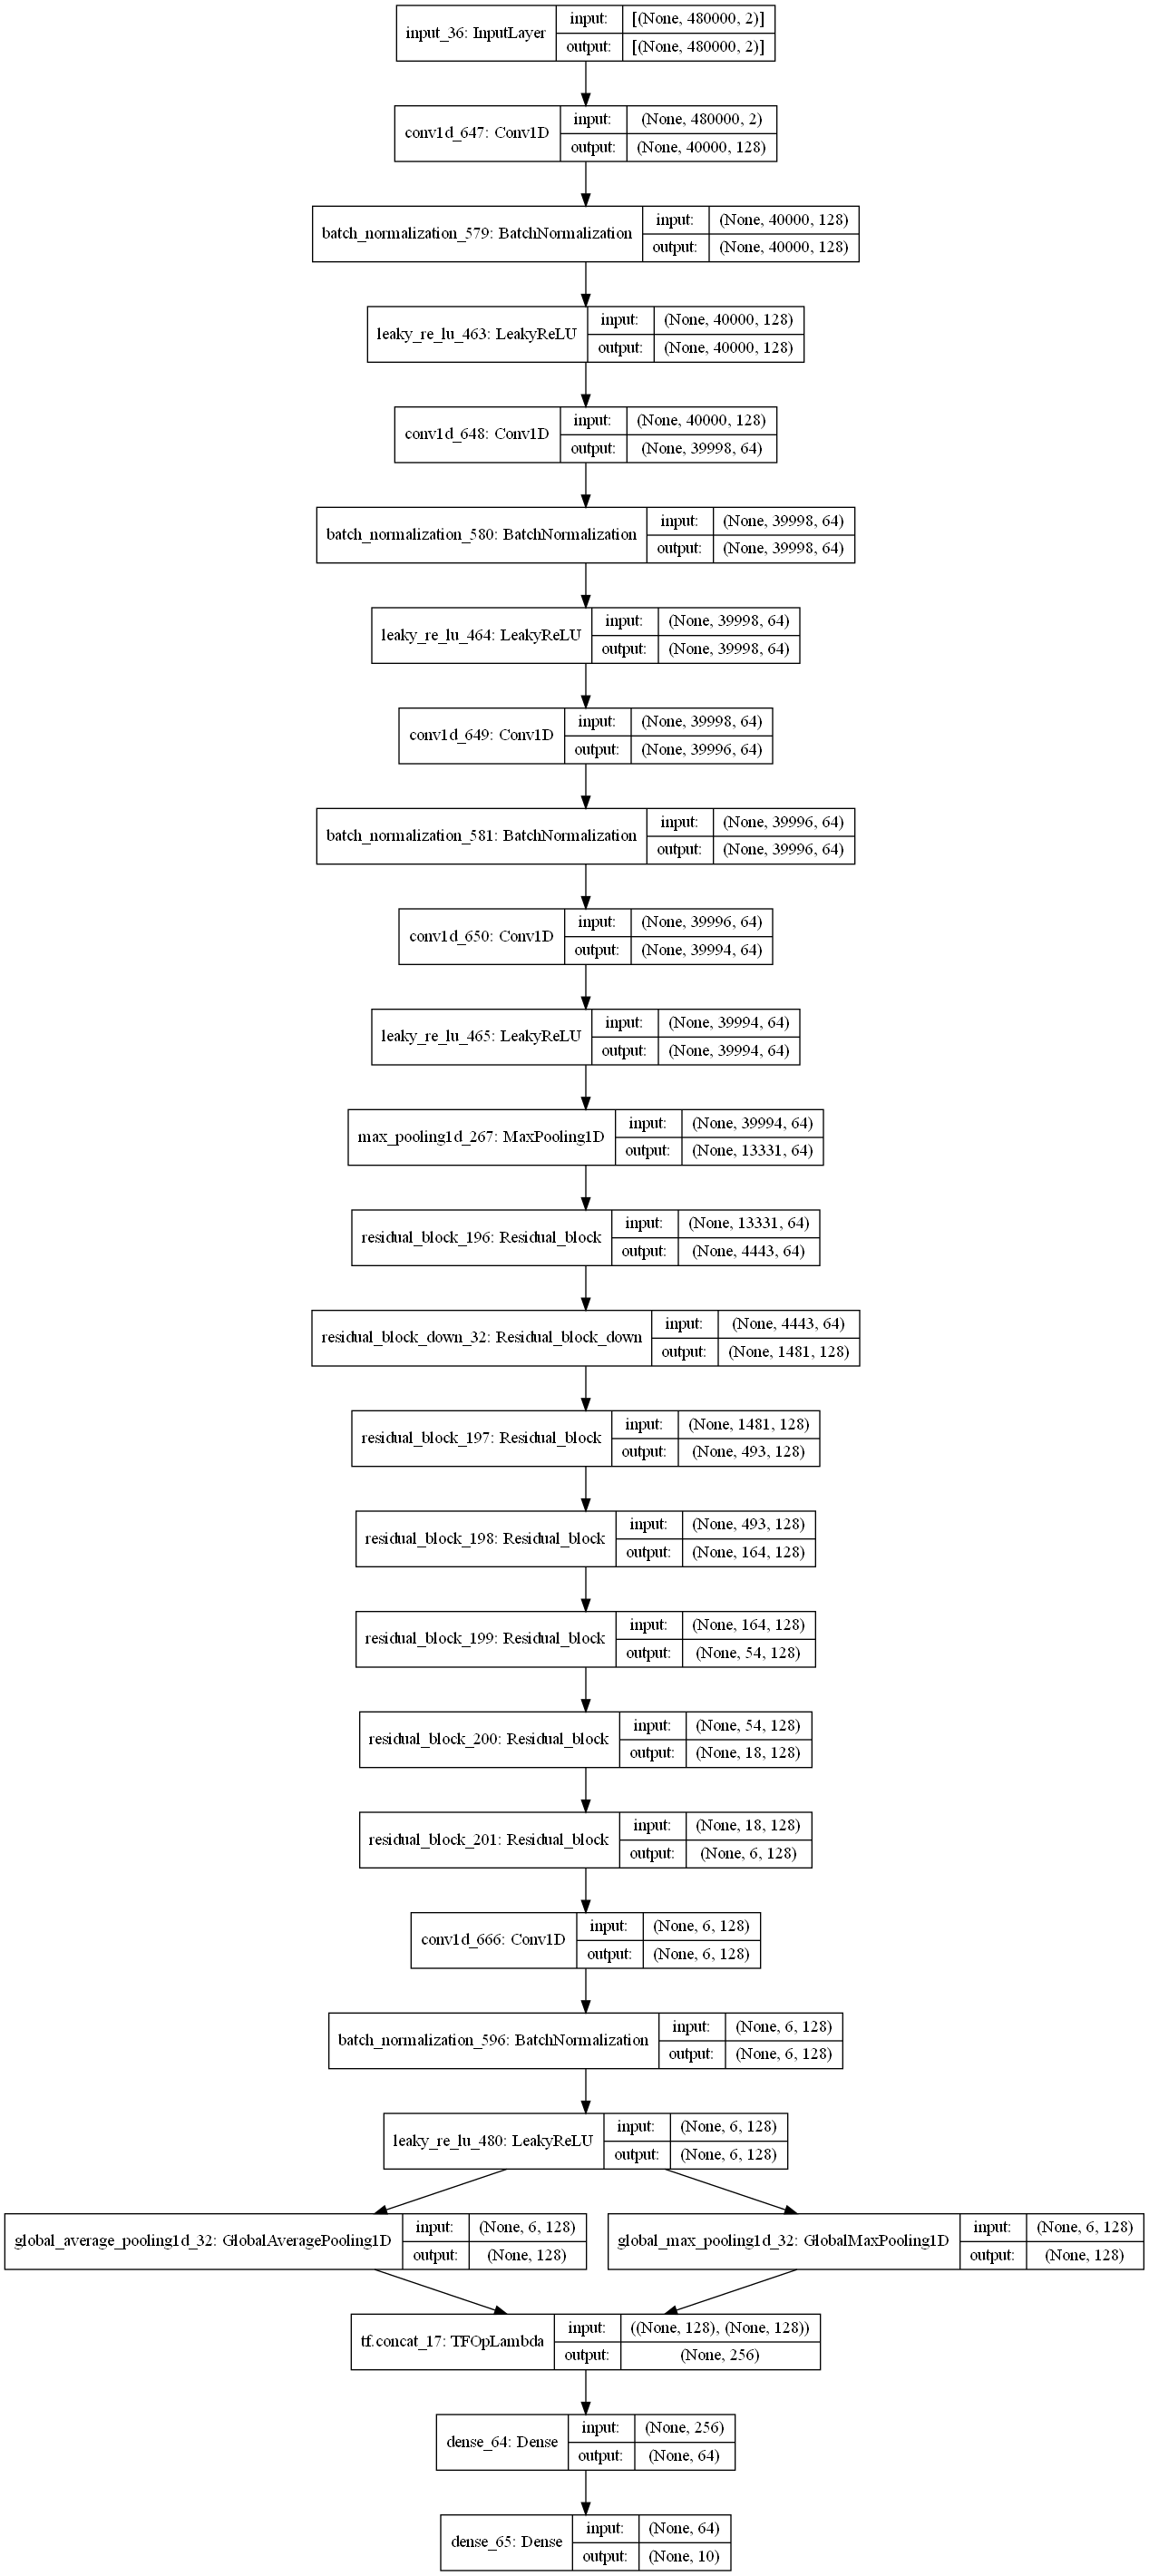

In [121]:
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [122]:
from datetime import datetime

if not os.path.exists('D:/Sean/github/dcase2019specialistkd/'+'model_Sean'):
    os.makedirs('D:/Sean/github/dcase2019specialistkd/'+'model_Sean')

checkpoint = tensorflow.keras.callbacks.ModelCheckpoint('D:/Sean/github/dcase2019specialistkd/'+'model_Sean/' + 'resnetmodel_epoch-{epoch:03d}-loss-{val_loss:.4f}-acc-{val_accuracy:.4f}',#.h5',
                                                        save_format='tf',monitor='val_loss', verbose=1, save_best_only=False) # This only saves the best performing model. To save all models, change save_best_only to False.
early = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10) # If the monitored value ("val_loss") doesn't change after 10 (patience) epochs, then stop training the model. #turning patience off for 2022
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='D:/Sean/github/dcase2019specialistkd/'+'model_Sean')
callbacks_list = [checkpoint, early, tensorboard_callback] #[checkpoint, early, tensorboard_callback]

In [123]:
resnetmodel_hist = model.fit(x=train_features,
                           y=train_labels,
                           batch_size = batch_size,
                           epochs = epochs,
                           initial_epoch = 0, # The label of the first epoch upon calling this function is one greater than this.
                                              # Call a number k > 0 to label the epochs starting from k+1 (useful for resuming training).
                           verbose = True,
                           validation_data =(eval_features,eval_labels),
                           #callbacks = callbacks_list,
                           shuffle = True)
model.save_weights('D:/Sean/github/dcase2019specialistkd/'+'model_Sean/' + 'resnetmodel_last', save_format ='tf')
#save_model_weights_tf(model, 'D:/Sean/github/dcase2019specialistkd/model_Sean/'+"my_weights")
#model.save('D:/Sean/github/dcase2019specialistkd/model_Sean/',save_format='tf')


Epoch 1/90
383/383 [==============================] - 950s 2s/step - loss: 0.0000e+00 - output_loss: 6.2903 - intvals_accuracy: 0.0130 - output_accuracy: 0.0670 - val_loss: 0.0000e+00 - val_output_loss: 7.2652 - val_intvals_accuracy: 0.0012 - val_output_accuracy: 0.1039
Epoch 2/90
383/383 [==============================] - 116s 304ms/step - loss: 0.0000e+00 - output_loss: 6.3360 - intvals_accuracy: 0.0123 - output_accuracy: 0.0645 - val_loss: 0.0000e+00 - val_output_loss: 6.0973 - val_intvals_accuracy: 0.0139 - val_output_accuracy: 0.0688
Epoch 3/90
383/383 [==============================] - 109s 284ms/step - loss: 0.0000e+00 - output_loss: 6.3380 - intvals_accuracy: 0.0127 - output_accuracy: 0.0628 - val_loss: 0.0000e+00 - val_output_loss: 6.0342 - val_intvals_accuracy: 0.0122 - val_output_accuracy: 0.0655
Epoch 4/90
383/383 [==============================] - 104s 272ms/step - loss: 0.0000e+00 - output_loss: 6.3286 - intvals_accuracy: 0.0131 - output_accuracy: 0.0630 - val_loss: 0.000

In [ ]:
# output_dict = model({'spec'})

## SVM Backend Classifier

We will use Scikit Learn to perform the SVM classification. Documentation for Scikit Learn can be found here:

https://scikit-learn.org/stable/modules/svm.html#classification

In [24]:
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [ ]:
svm_x = invals
svm_y = train_

In [ ]:

SVM_list = []
			acc = []
			classwise_acc = []
			for cov_type in ['rbf', 'sigmoid']:
				score_list = []
				
				SVM_list.append(SVC(kernel=cov_type,
                        gamma='scale',
                        probability = True))
				SVM_list[-1].fit(invals,output) #placeholder data, check again later
				
    			num_corr = 0
				num_corr_class = [0]* len(l_class_ans)
				num_predict_class = [0] * len(l_class_ans)
		
				score_list = SVM_list[-1].predict(embeddings_dev)

# Baseline Model Implemented by Kenneth

In [ ]:
bl_in = Input(shape = (44100,1), name = 'bl_in', sparse = False)
bl_conv2dA = Conv2D(16, (7,7), padding = 'same', data_format = 'channels_last', name = 'bl_conv2dA')(bl_in)
bl_bnA = BatchNormalization(name = 'bl_bnA')(bl_conv2dA)
bl_actA = Activation('relu', name = 'bl_actA')(bl_bnA)

#bl_mpA = MaxPooling2D(pool_size = (5,5), name = 'bl_mpA')(bl_actA)
#bl_dropA = Dropout(0.3, name = 'bl_dropA')(bl_mpA)

bl_conv2dB = Conv2D(16, (7,7), padding = 'same', data_format = 'channels_last', name = 'bl_conv2dB')(bl_actA)
bl_bnB = BatchNormalization(name = 'bl_bnB')(bl_conv2dB)
bl_actB = Activation('relu', name = 'bl_actB')(bl_bnB)
bl_mpB = MaxPooling2D(pool_size = (5,5), name = 'bl_mpB')(bl_actB)
bl_dropB = Dropout(0.3, name = 'bl_dropB')(bl_mpB)

bl_conv2dC = Conv2D(32, (7,7), padding = 'same', data_format = 'channels_last', name = 'bl_conv2dC')(bl_dropB)
bl_bnC = BatchNormalization(name = 'bl_bnC')(bl_conv2dC)
bl_actC = Activation('relu', name = 'bl_actC')(bl_bnC)
bl_mpC = MaxPooling2D(pool_size = (4,10), name = 'bl_mpC')(bl_actC)
bl_dropC = Dropout(0.3, name = 'bl_dropC')(bl_mpC)

bl_flatten = Flatten(name = 'bl_flatten')(bl_dropC)
bl_fcA = Dense(100, activation = 'relu', kernel_initializer = 'uniform', name = 'bl_fcA')(bl_flatten)
bl_dropD = Dropout(0.3, name = 'bl_dropD')(bl_fcA)
bl_fcB = Dense(10, activation = 'softmax', kernel_initializer = 'uniform', name = 'bl_fcB')(bl_dropD)

blmodel = Model(inputs = bl_in, outputs = bl_fcB)

Let's look at the model summary in full.

In [ ]:
blmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bl_in (InputLayer)           [(None, 40, 50, 1)]       0         
_________________________________________________________________
bl_conv2dA (Conv2D)          (None, 40, 50, 16)        800       
_________________________________________________________________
bl_bnA (BatchNormalization)  (None, 40, 50, 16)        64        
_________________________________________________________________
bl_actA (Activation)         (None, 40, 50, 16)        0         
_________________________________________________________________
bl_conv2dB (Conv2D)          (None, 40, 50, 16)        12560     
_________________________________________________________________
bl_bnB (BatchNormalization)  (None, 40, 50, 16)        64        
_________________________________________________________________
bl_actB (Activation)         (None, 40, 50, 16)        0   

Now, we shall compile the model with the learning parameters used in the baseline model.

In [ ]:
batch_size = 16
epochs = 2
learning_rate = 0.001 # Use adam.
shuffle = True

In [ ]:
blmodel.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate), # The best optimiser to use might depend on your data, but in general the adam optimiser performs pretty well.
                loss='categorical_crossentropy', # categorical crossentropy is a standard function for single-label classification. 
                metrics=['accuracy']) # Is NOT optimised over, but is something that is shown when training.

As the penultimate step before training, we will define the callbacks to be used before calling `model.fit`.

In [ ]:
from datetime import datetime

if not os.path.exists('..'+os.sep+'model_Sean'):
    os.makedirs('..'+os.sep+'model_Sean')

checkpoint = tensorflow.keras.callbacks.ModelCheckpoint('..'+os.sep+'model_Sean'+os.sep + str(datetime.now()).split(' ')[0] + '_blmodel_epoch-{epoch:03d}-loss-{val_loss:.4f}-acc-{val_accuracy:.4f}.h5',
                                                        monitor='val_loss', verbose=1, save_best_only=False) # This only saves the best performing model. To save all models, change save_best_only to False.
early = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=50) # If the monitored value ("val_loss") doesn't change after 10 (patience) epochs, then stop training the model. #turning patience off for 2022
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='..'+os.sep+'model_Sean')
callbacks_list = [checkpoint, early, tensorboard_callback] #[checkpoint, early, tensorboard_callback]

Now, we call `model.fit`. The baseline model should have somewhere between 44.0% - 44.5% accuracy on the validation (evaluation) set. Note that for some reason, the model history objects (`blmodel_hist` here) cannot be saved simply by using `np.save` (although it worked with TF1). If any important values need to be saved from the model history, please use the dot operator to access the respective objects and save them individually. With a GPU, the model should take about 20-30 minutes to train.

Logloss should be between 1.490 - 1.574

In [ ]:
blmodel_hist = blmodel.fit(train_features,
                           train_labels,
                           batch_size = batch_size,
                           epochs = epochs,
                           initial_epoch = 0, # The label of the first epoch upon calling this function is one greater than this.
                                              # Call a number k > 0 to label the epochs starting from k+1 (useful for resuming training).
                           verbose = 1,
                           validation_data =(eval_features,eval_labels),
                           callbacks = callbacks_list,
                           shuffle = True)
blmodel.save_weights('..'+os.sep+'model_Sean'+os.sep + 'blmodel_last.h5')

Train on 139620 samples, validate on 29680 samples
Epoch 1/2
 20192/139620 [===>..........................] - ETA: 44s - loss: 2.3026 - accuracy: 0.1011

KeyError: 'val_loss'

Lastly, we shall save the model history (not the entire history object):

In [ ]:
np.save('..'+os.sep+'model_Sean'+os.sep+'blmodel_hist.npy',blmodel_hist.history,allow_pickle=True)

NameError: name 'blmodel_hist' is not defined

As a side note, if you are interested to explore the history object, below is some sample code (irrelevant to the main task at hand, so we comment it out):

In [ ]:
# Sample code to reload history as dictionary.
x = np.load('..'+os.sep+'model_Sean'+os.sep+'blmodel_hist.npy', allow_pickle = True).item()

print(x.keys())


# Sample code to check attributes of history object.
#for attribute in dir(blmodel_hist):
    #print('blmodel_hist.' + attribute + '       ' + str(type(eval( 'blmodel_hist.' + attribute  ))))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Extract Best Performing Model

Now, we will go through all the `.h5` model files that were saved from `model.fit` and obtain the best model from those files. Let's look at the first few files that were saved in the `model_Kenneth` directory:

In [ ]:
os.listdir('..'+os.sep+'model_Sean')[:5]

['2023-03-08_blmodel_epoch-001-loss-1.7257-acc-0.3513.h5',
 '2023-03-08_blmodel_epoch-002-loss-1.7336-acc-0.3621.h5',
 '2023-03-08_blmodel_epoch-003-loss-1.7119-acc-0.3721.h5',
 '2023-03-08_blmodel_epoch-004-loss-1.8469-acc-0.3405.h5',
 '2023-03-08_blmodel_epoch-005-loss-1.6846-acc-0.3812.h5']

Now, we run the following block to tell us which file has the highest validation accuracy, and what that accuracy is:

In [ ]:
highestacc = 0
highestepoch = 0
highestfilepath = 'D:\Sean\DCASE\model_Sean'
todays_date = str(datetime.now()).split(' ')[0] # We assume that the entire notebook was run on the same day.
                                                # If not, replace this string with a string of the form 'yyyy-mm-dd' specifying the date that the model.fit command was run.
    
for idx, file in enumerate(os.listdir('..'+os.sep+'model_Sean')):
    if file.find('2023-') != -1: # If file starts with year of timestamp, then it is a model file (.h5)
        #print('idx = {}, acc = {}, highestacc = {}, highestepoch = {}'.format(
        #      idx, int(file.split('-')[-1].split('.')[1]), highestacc, highestepoch) )
        if int(file.split('-')[-1].split('.')[1]) > highestacc:
            highestacc = int(file.split('-')[-1].split('.')[1])
            highestepoch = int(file.split('-')[3])
            highestfile = str(file)
            print(file)

print('Highest accuracy achieved = {} on epoch {}'.format(highestacc/10000, highestepoch))
model_path = os.path.join(highestfilepath,highestfile)
print(model_path)

2023-03-08_blmodel_epoch-001-loss-1.7257-acc-0.3513.h5
2023-03-08_blmodel_epoch-002-loss-1.7336-acc-0.3621.h5
2023-03-08_blmodel_epoch-003-loss-1.7119-acc-0.3721.h5
2023-03-08_blmodel_epoch-005-loss-1.6846-acc-0.3812.h5
Highest accuracy achieved = 0.3812 on epoch 5
D:\Sean\DCASE\model_Sean\2023-03-08_blmodel_epoch-005-loss-1.6846-acc-0.3812.h5


`highestacc` gives the highest accuracy produced after `model.fit` has finished running, and `highestepoch` gives the epoch in which the highest accuracy occurred.

We should get an accuracy of 44.0% - 44.5% as reported by the challenge organisers <a href="https://dcase.community/challenge2022/task-low-complexity-acoustic-scene-classification#results"> here</a>.

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir "../model_Sean"

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 3908.

# Loading The Model Back
Load Unquantized model

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(2022)
import pathlib
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Include this line to force TensorFlow to run with the CPU instead of GPU. It must be placed BEFORE importing tensorflow,
                                          # otherwise tensorflow will default to the GPU for computing. Will need to restart kernel if you want to run with GPU again.
# os.environ["CUDA_VISIBLE_DEVICES"]="2" # Include this line if you have multiple GPUs available for training and want to select the 2nd GPU.
                                         # If you only have one GPU then leaving it empty is fine. Need tensorflow-gpu installed + a GPU in your system + CUDA drivers.

import tensorflow
tensorflow.random.set_seed(2020) # ALWAYS set the random seed for tensorflow before importing any other related Keras packages.
                                 # If using Tensorflow versions less than 2.0.0, change this line to tensorflow.set_random_seed(2019)

import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt

# Allow matplotlib plots to display properly in the notebook.
%matplotlib inline 

from datetime import datetime # Used to label output model files.
from useful_functions import * # Load our own useful_functions module.

In [ ]:
import tensorflow
import tensorflow as tf

In [ ]:
highestacc = 0
highestepoch = 0
highestfilepath = 'D:\Sean\DCASE\model_Sean'
todays_date = str(datetime.now()).split(' ')[0] # We assume that the entire notebook was run on the same day.
                                                # If not, replace this string with a string of the form 'yyyy-mm-dd' specifying the date that the model.fit command was run.
    
for idx, file in enumerate(os.listdir('..'+os.sep+'model_Sean')):
    if file.find('2023-') != -1: # If file starts with year of timestamp, then it is a model file (.h5)
        #print('idx = {}, acc = {}, highestacc = {}, highestepoch = {}'.format(
        #      idx, int(file.split('-')[-1].split('.')[1]), highestacc, highestepoch) )
        if int(file.split('-')[-1].split('.')[1]) > highestacc:
            highestacc = int(file.split('-')[-1].split('.')[1])
            highestepoch = int(file.split('-')[3])
            highestfile = str(file)
            print(file)

print('Highest accuracy achieved = {} on epoch {}'.format(highestacc/10000, highestepoch))
model_path = os.path.join(highestfilepath,highestfile)
print(model_path)

2023-03-08_blmodel_epoch-001-loss-1.7257-acc-0.3513.h5
2023-03-08_blmodel_epoch-002-loss-1.7336-acc-0.3621.h5
2023-03-08_blmodel_epoch-003-loss-1.7119-acc-0.3721.h5
2023-03-08_blmodel_epoch-005-loss-1.6846-acc-0.3812.h5
Highest accuracy achieved = 0.3812 on epoch 5
D:\Sean\DCASE\model_Sean\2023-03-08_blmodel_epoch-005-loss-1.6846-acc-0.3812.h5


In [ ]:
blmodel = tf.keras.models.load_model(model_path)

NameError: name 'keras' is not defined

In [ ]:
from tensorflow.keras.utils import to_categorical

train_features = np.load('..'+os.sep+'features_Sean'+os.sep+'baseline_train_features.npy',allow_pickle=True)
eval_features = np.load('..'+os.sep+'features_Sean'+os.sep+'baseline_eval_features.npy',allow_pickle=True)
train_labels = to_categorical(np.load('..'+os.sep+'features_Sean'+os.sep+'baseline_train_labels.npy',allow_pickle=True))
eval_labels = to_categorical(np.load('..'+os.sep+'features_Sean'+os.sep+'baseline_eval_labels.npy',allow_pickle=True))

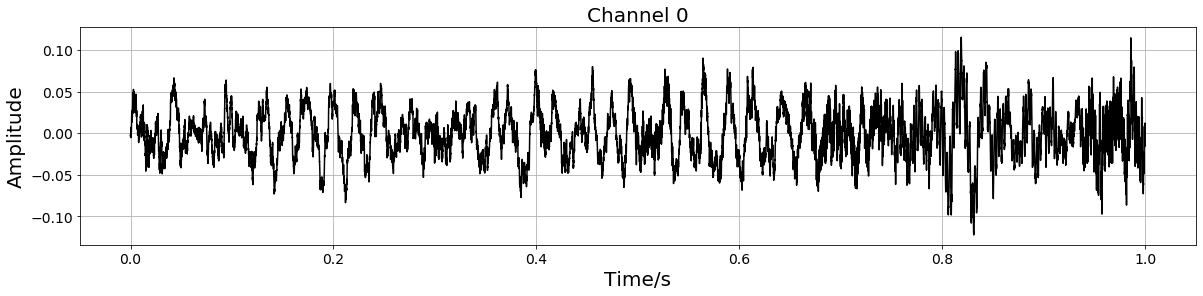

In [ ]:
import librosa
filedir = '..' + os.sep + 'datasets' +os.sep + 'Extract_to_Folder' + os.sep + 'TAU-urban-acoustic-scenes-2022-mobile-development' + os.sep + 'audio' + os.sep
x, sr = librosa.load(filedir + 'airport-barcelona-0-0-0-a.wav',
                 mono = True,
                 sr = 44100)

from useful_functions import *
plot_time_domain_signal_and_track(x, sr = sr, normalize_audio_player=True)

# Model Evaluation

We have already combined this step when specifiying validation data in `.fit` but I will include it here for reference

In [ ]:
test_loss, test_acc = blmodel.evaluate(eval_features, eval_labels, verbose=1) 

print('Test accuracy:', test_acc)

# Load Test Dataset (Prediction)
We now want to perform inference (predictions) and see what the accuracy is. The evaluation (testing) dataset will only be released in May 

In [ ]:
test_files = pd.read_csv(r'D:\Sean\DCASE\datasets\evaluation_setup\fold1_test.csv', #evaluation done on evaluation dataset
                      delimiter = '\t')

In [ ]:
test_files = pd.read_csv(r'D:\Sean\DCASE\datasets\development_setup\fold1_test.csv', #evaluation done on development dataset
                      delimiter = '\t')

In [ ]:
print(test_files)

                                       filename
0      audio/airport-barcelona-203-6129-0-a.wav
1      audio/airport-barcelona-203-6129-1-a.wav
2      audio/airport-barcelona-203-6129-2-a.wav
3      audio/airport-barcelona-203-6129-3-a.wav
4      audio/airport-barcelona-203-6129-4-a.wav
...                                         ...
29675     audio/tram-lisbon-1200-45650-5-s6.wav
29676     audio/tram-lisbon-1200-45650-6-s6.wav
29677     audio/tram-lisbon-1200-45650-7-s6.wav
29678     audio/tram-lisbon-1200-45650-8-s6.wav
29679     audio/tram-lisbon-1200-45650-9-s6.wav

[29680 rows x 1 columns]


In [ ]:
start_time = datetime.now()
test_features = np.empty(shape=(len(test_files),40,50,1))
for i in range(len(test_files)):
    filepath = "Extract_to_Folder/TAU-urban-acoustic-scenes-2022-mobile-evaluation" + os.sep + test_files.loc[i].at["filename"]
    x, sr = librosa.load(filepath,mono = True,sr = sr)
    s = audio_to_mel_magnitude_spectrogram(x,
                                           sr=sr,
                                           n_fft=int(0.04*sr)-1024,
                                           hop_length=int(0.02*sr), # unverified
                                           center = False, # unverified
                                           n_mels = 40,
                                           fmin = 0,
                                           fmax = sr//2,
                                           ref = 1.0, # unverified
                                           plot_spectrogram = False)
    test_features[i] = s
    if i%1000 == 0:
        print('Now on test sample: ' + str(i))
end_time = datetime.now()
print('Time elapsed: ' + str(end_time - start_time))

# Make directory to save features if it doesn't already exist.
if not os.path.exists('..' + os.sep + 'eval_features_Sean'):
    os.makedirs('..' + os.sep + 'eval_features_Sean')
np.save('..'+os.sep+'eval_features_Sean'+os.sep+'baseline_test_features.npy',test_features,allow_pickle=True)

In [ ]:
start_time = datetime.now()
test_features = np.empty(shape=(len(test_files),40,50,1))
for i in range(len(test_files)):
    filepath = "Extract_to_Folder/TAU-urban-acoustic-scenes-2022-mobile-development" + os.sep + test_files.loc[i].at["filename"]
    x, sr = librosa.load(filepath,mono = True,sr = sr)
    s = audio_to_mel_magnitude_spectrogram(x,
                                           sr=sr,
                                           n_fft=int(0.04*sr)-1024,
                                           hop_length=int(0.02*sr), # unverified
                                           center = False, # unverified
                                           n_mels = 40,
                                           fmin = 0,
                                           fmax = sr//2,
                                           ref = 1.0, # unverified
                                           plot_spectrogram = False)
    test_features[i] = s
    if i%1000 == 0:
        print('Now on test sample: ' + str(i))
end_time = datetime.now()
print('Time elapsed: ' + str(end_time - start_time))

# Make directory to save features if it doesn't already exist.
if not os.path.exists('..' + os.sep + 'features_Sean'):
    os.makedirs('..' + os.sep + 'features_Sean')
np.save('..'+os.sep+'features_Sean'+os.sep+'baseline_test_features.npy',test_features,allow_pickle=True)

Now on test sample: 0
Now on test sample: 1000
Now on test sample: 2000
Now on test sample: 3000
Now on test sample: 4000
Now on test sample: 5000
Now on test sample: 6000
Now on test sample: 7000
Now on test sample: 8000
Now on test sample: 9000
Now on test sample: 10000
Now on test sample: 11000
Now on test sample: 12000
Now on test sample: 13000
Now on test sample: 14000
Now on test sample: 15000
Now on test sample: 16000
Now on test sample: 17000
Now on test sample: 18000
Now on test sample: 19000
Now on test sample: 20000
Now on test sample: 21000
Now on test sample: 22000
Now on test sample: 23000
Now on test sample: 24000
Now on test sample: 25000
Now on test sample: 26000
Now on test sample: 27000
Now on test sample: 28000
Now on test sample: 29000
Time elapsed: 0:06:31.351529


In [ ]:
test_features = np.load('..'+os.sep+'features_Sean'+os.sep+'baseline_test_features.npy',allow_pickle=True)

In [ ]:
print('Number of test files: ' + str(len(test_files))) # 118800


Number of test files: 29680


# Model Prediction

We can view the predicted label of each test file by changing the index of the print statement.

Recall the following:

`class_labels = ['airport','shopping_mall','metro_station', 'street_pedestrian', 'public_square','street_traffic','tram','bus','metro','park']`

In [ ]:
class_labels = ['airport','shopping_mall','metro_station', 'street_pedestrian', 'public_square','street_traffic','tram','bus','metro','park']

In [ ]:
prediction = (blmodel.predict(test_features))

In [ ]:
#Clone the dataframe so we can perform in-place operations without changing the data
test_files2 = test_files.copy()
#Creating Prediction label list
predict_label = []
for i in range(len(test_files)):
    pred_index = np.argmax(prediction[i]) 
    predict_label.append(class_labels[pred_index])

#Insert scene label list into dataframe
test_files2.insert(1,"predict_label",predict_label)

#Insert a new column called scene_label
scene_label = []
for j in range(len(test_files)):
    start = test_files['filename'][j].index('/')
    end = test_files['filename'][j].index('-',start+1)
    substring = test_files['filename'][j][start+1:end]
    scene_label.append(substring)

test_files2.insert(1,"scene_label",scene_label)


In [ ]:
print(test_files2)

                                       filename scene_label predict_label
0      audio/airport-barcelona-203-6129-0-a.wav     airport       airport
1      audio/airport-barcelona-203-6129-1-a.wav     airport       airport
2      audio/airport-barcelona-203-6129-2-a.wav     airport       airport
3      audio/airport-barcelona-203-6129-3-a.wav     airport       airport
4      audio/airport-barcelona-203-6129-4-a.wav     airport       airport
...                                         ...         ...           ...
29675     audio/tram-lisbon-1200-45650-5-s6.wav        tram       airport
29676     audio/tram-lisbon-1200-45650-6-s6.wav        tram       airport
29677     audio/tram-lisbon-1200-45650-7-s6.wav        tram       airport
29678     audio/tram-lisbon-1200-45650-8-s6.wav        tram       airport
29679     audio/tram-lisbon-1200-45650-9-s6.wav        tram       airport

[29680 rows x 3 columns]


In [ ]:
matches = test_files2['scene_label'] == test_files2['predict_label']
match_percentage = matches.mean() * 100

print(f"Percentage of matching elements: {match_percentage:.2f}%")

Percentage of matching elements: 9.97%


# Generate the Confusion Matrix

In [ ]:
y_ = []
y = []
for i in range(len(test_files)):
    #Create prediction list
    pred_index = np.argmax(prediction[i])
    y.append(pred_index)
    #Create actual label list
    y_.append(class_labels.index(test_files2['scene_label'][i]))

In [ ]:
confusion = tf.math.confusion_matrix(labels=y_, predictions=y, num_classes=10)
print(confusion)

tf.Tensor(
[[2960    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2960    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]
 [2970    0    0    0    0    0    0    0    0    0]], shape=(10, 10), dtype=int32)


Text(0.5, 0.98, 'Plot of confusion matrix')

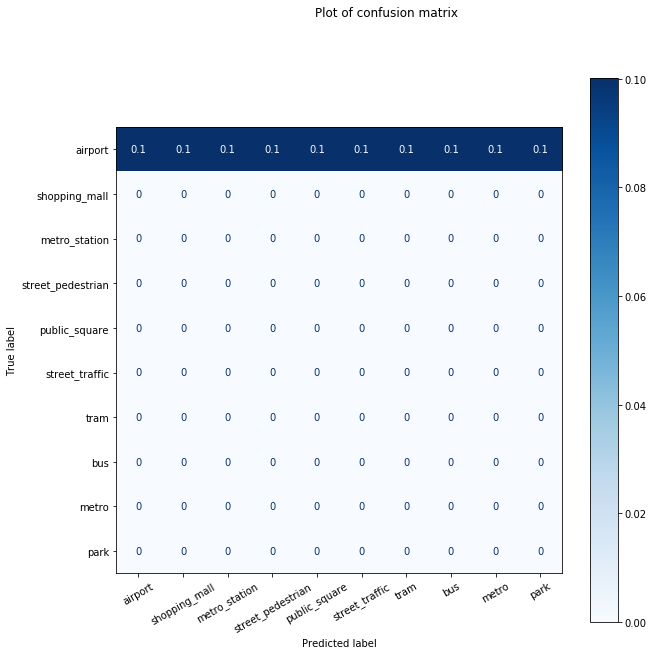

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = y_
y_test = y
#cm = confusion_matrix(y_pred, y_test, normalize = 'true')
#cmd = confusion_matrix_display
disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              y_pred, 
                                              display_labels=class_labels,
                                              normalize = 'true',
                                              cmap=plt.cm.Blues,
                                              xticks_rotation=30
)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix')


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['airport','shopping_mall','metro_station', 'street_pedestrian', 'public_square','street_traffic','tram','bus','metro','park']))


Accuracy: 0.10

Micro Precision: 0.10
Micro Recall: 0.10
Micro F1-score: 0.10

Macro Precision: 0.10
Macro Recall: 0.01
Macro F1-score: 0.02

Weighted Precision: 1.00
Weighted Recall: 0.10
Weighted F1-score: 0.18

Classification Report

                   precision    recall  f1-score   support

          airport       1.00      0.10      0.18     29680
    shopping_mall       0.00      0.00      0.00         0
    metro_station       0.00      0.00      0.00         0
street_pedestrian       0.00      0.00      0.00         0
    public_square       0.00      0.00      0.00         0
   street_traffic       0.00      0.00      0.00         0
             tram       0.00      0.00      0.00         0
              bus       0.00      0.00      0.00         0
            metro       0.00      0.00      0.00         0
             park       0.00      0.00      0.00         0

         accuracy                           0.10     29680
        macro avg       0.10      0.01      0.02    

C:\Users\eeeds\anaconda3\envs\dcase\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eeeds\anaconda3\envs\dcase\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eeeds\anaconda3\envs\dcase\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eeeds\anaconda3\envs\dcase\lib\site-packages\sklearn\metrics\_c

# Model Quantization
For DCASE 2022 and later, we need to run the inference on an integer quantized model. To do so, we must first convert the model to TFlite.
We save the model using `model.save` as shown in the official tensorflow documentation <a href="https://www.tensorflow.org/lite/models/convert"> here</a>.

In [ ]:
if not os.path.exists('..'+os.sep+'quant_model_Sean'):
    os.makedirs('..'+os.sep+'quant_model_Sean')
    

In [ ]:
quant_model_path = 'D:\Sean\DCASE\quant_model_Sean'

In [ ]:
print(quant_model_path)
blmodel.save(quant_model_path)

D:\Sean\DCASE\quant_model_Sean
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Sean\DCASE\quant_model_Sean\assets


## Post Training Quantization (int8)
Our tensorflow version is older than 2.7 so we must generate representative dataset with a batch generator

In [ ]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((train_features)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(blmodel)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # converts to int32
converter.representative_dataset = representative_dataset

In [ ]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = [tf.int8]  # or tf.uint8
converter.inference_output_type = [tf.int8]  # or tf.uint8
tflite_model = converter.convert()

## Save the TFlite model

In [ ]:
tflite_model_file = pathlib.Path(quant_model_path + '/pretrainedmodel.tflite')
tflite_model_file.write_bytes(tflite_model)

## Loading the TFlite model Back

In [ ]:
quant_model_path = 'D:\Sean\DCASE\quant_model_Sean'

In [ ]:
interpreter = tf.lite.Interpreter(model_path= quant_model_path + '/pretrainedmodel.tflite')

## Setting up Quantization for TFlite Model

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

In [ ]:
# Allocate tensors
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


## Visualizing the input and output data
We can see what the TFlite model is expecting for its' input and output

In [ ]:
print('input shape:', input_details[0]['shape'])
print('input type:', input_details[0]['dtype'])
print('output shape:', output_details[0]['shape'])
print('output type:', output_details[0]['dtype'])

input shape: [ 1 40 50  1]
input type: <class 'numpy.float32'>
output shape: [ 1 10]
output type: <class 'numpy.float32'>


We see that it is only expecting 1 input tensor. To fix this, we have to expand the dimensions of the tensors using `np.expand_dims`

# Inference
What I've done is basically written a loop to iterate through each test feature tensor, assign it as the input tensor and invoke the interpreter to get a prediction. I get the prediction and append it to a list `y`. While iterating through the features, I use the prediction to return the class label and append it to another list `predict_label`. We will use these lists to measure the accuracy of the quantized model either via the `matches.mean()` method or confusion matrix

In [ ]:
y = []
predict_label = []
input_shape = input_details[0]['shape']
print(input_shape)
for i in range(len(test_features)):
    input_tensor = np.array(np.expand_dims(test_features[i],0),dtype=np.float32) #initialize the input tensor
    input_index = interpreter.get_input_details()[0]["index"] #get the index of the input tensor
    interpreter.set_tensor(input_index,input_tensor) # set the input tensor
    interpreter.invoke() # Run inference on each sample
    output_details = interpreter.get_output_details() # Get details of output
    output_data = interpreter.get_tensor(output_details[0]["index"]) # get the data from the output
    #print('output data:', output_data) #check data structure
    results = np.squeeze(output_data) # Should be a nice output now
    #print('results' ,results)
    pred_index = results.argmax() #get class prediction
    #print('pred_index' ,pred_index)
    y.append(pred_index)
    #print('y:' ,y)
    predict_label.append(class_labels[pred_index])  
print(predict_label)    

In [ ]:
tfdf = pd.DataFrame()
tfdf.insert(0,"predict_label",predict_label)
tfdf.insert(0,"scene_label",scene_label)

In [ ]:
print(tfdf)

      scene_label      predict_label
0         airport  street_pedestrian
1         airport  street_pedestrian
2         airport      metro_station
3         airport            airport
4         airport            airport
...           ...                ...
29675        tram  street_pedestrian
29676        tram              metro
29677        tram              metro
29678        tram               tram
29679        tram               tram

[29680 rows x 2 columns]


# Acc Method
Can try this too

In [ ]:
matches = tfdf['scene_label'] == tfdf['predict_label']
match_percentage = matches.mean() * 100

print(f"Percentage of matching elements: {match_percentage:.2f}%")

Percentage of matching elements: 40.04%


# Non-looping Method

https://www.youtube.com/watch?v=OJnaBhCixng&t=3308s